<a href="https://colab.research.google.com/github/maria-angslz/Inteligencia-Artificial/blob/main/IAA_TP_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TP Grupal

---


Inteligencia Artificial Avanzada

* Importar modulos para conectarse al drive
* Montar drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Descargar imagenes y descomprimir


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/My Drive/IAA-TP/dataset/imagenes.zip', 'r') as zipObj:
    zipObj.extractall('/content')

with ZipFile('/content/drive/My Drive/IAA-TP/dataset/test.zip', 'r') as zipObj:
    zipObj.extractall('/content')

Importar modulos de TensorFlow y otros

In [ ]:
import matplotlib.pyplot as plt
from pylab import imread,subplot,imshow,show
import cv2
import numpy as np
import pathlib
import PIL
import requests
import io
import pandas as pd
from urllib.request import urlopen
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [ ]:
data_dir = '/content/imagenes'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))

print(f"cantidad de Imagenes: {image_count}")

cantidad de Imagenes: 300


In [ ]:
batch_size = 32
img_height = 256
img_width = 256


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)


Found 300 files belonging to 2 classes.
Using 240 files for training.
Found 300 files belonging to 2 classes.
Using 60 files for validation.
['estatua', 'persona']


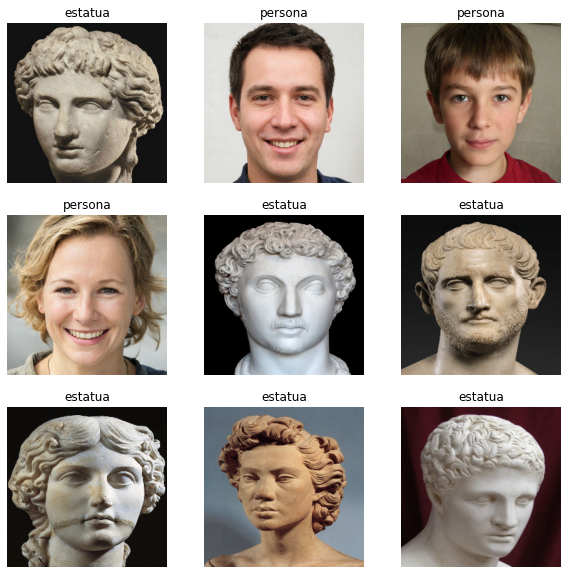

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


Cargar en memoria para mejorar el rendimiento

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = keras.Sequential(
 [
   layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
   layers.experimental.preprocessing.RandomRotation(0.1),
   layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)


Definir el modelo

In [ ]:
num_classes = len(class_names)
padding = 'same'
kernel_size = 3

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Normaliza los datos que del reango 0-255 (8 bits discreto) al rango 0-1 (Continuo) 
  layers.Conv2D(16, kernel_size, padding=padding, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, kernel_size, padding=padding, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, kernel_size, padding=padding, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding=padding, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax') #agregue la capa de salida softmax, con esto va a devolver un porcentaje de probabilidad de pertenencia de la imagen a estatua o persona. 
])


In [ ]:
model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

model.summary()

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from termcolor import colored

def predictImages(real_class, images):
  correctas = 0
  incorrectas = 0

  for img_url in images:
    
    img = keras.preprocessing.image.load_img(img_url, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    name = str(img_url).split('/')[-1]

    predict_class = class_names[np.argmax(score)]

    if predict_class == real_class:
      veracity = colored('Correctamente', 'green')
      correctas += 1
    else:
      veracity = colored('Incorrectamente', 'red')
      incorrectas += 1

    percent = str(round(100 * np.max(score), 2)) + " %"

    #print(f"La imagen {colored(name, 'grey')} es una {colored(real_class, 'blue')} y se la clasifica {veracity} como {colored(predict_class, 'blue')} con una exactitud de {colored(percent, 'yellow')}")
    

  print(f"De {colored(len(images), 'blue')} imagenes se clasifican {colored(correctas, 'green')} correctamente y {colored(incorrectas, 'red')} incorrectamente")


data_dir = pathlib.Path('/content/drive/MyDrive/IAA-TP/dataset/test')

test_files = [[class_name, list(data_dir.glob(f"{class_name}/*.jpg"))] for class_name in class_names]


for label, test_images in test_files:
  print(f"Clasificando {label}")
  predictImages(label, test_images)


Clasificando estatua
De 10 imagenes se clasifican 0 correctamente y 10 incorrectamente
Clasificando persona


La imagen ADGmqu_ppttOiUY5V-stL6Y0WnY6o0mzpd5E53oFJDWBnA=s83-c-mo es una persona y se la clasifica Correctamente como persona con una exactitud de 73.11 %


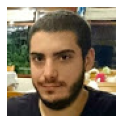

In [ ]:
img_url = "https://lh3.googleusercontent.com/ogw/ADGmqu_ppttOiUY5V-stL6Y0WnY6o0mzpd5E53oFJDWBnA=s83-c-mo"
name = str(img_url).split('/')[4]
class_ = class_names[1] # 0 - estatua || 1 - persona

#img_path = tf.keras.utils.get_file('test', origin=img_url)

#img = keras.preprocessing.image.load_img(img_url, target_size=(img_height, img_width))

def get(url):
    with urlopen(str(url.numpy().decode("utf-8"))) as request:
        img_array = np.asarray(bytearray(request.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def read_image_from_url(url):
    return tf.py_function(get, [url], tf.uint8)

image = read_image_from_url(img_url)

#img_array = keras.preprocessing.image.img_to_array(img)
#img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predict_class = class_names[np.argmax(score)]
veracity  = colored('Correctamente', 'green') if predict_class == class_ else colored('Incorrectamente', 'red')
percent = str(round(100 * np.max(score), 2)) + " %"

#image = imread(img_url)
plt.figure(figsize=(2, 2))
plt.imshow(image)
#plt.title(f"{name} {class_} {percent}")
plt.axis("off")

print(f"La imagen {colored(name, 'grey')} es una {colored(class_, 'blue')} y se la clasifica {veracity} como {colored(predict_class, 'blue')} con una exactitud de {colored(percent, 'yellow')}")


In [ ]:
from termcolor import colored
from time import sleep

data_dir = pathlib.Path('/content/test/')
test = data_dir.glob('*/*.jpg')
i = 0
class_real, class_preds = [], []

for img_url in test:
    class_ = [class_ for class_ in class_names if class_ in str(img_url)][0]

    img = keras.preprocessing.image.load_img(img_url, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    name = str(img_url).split('/')[-1]

    predict_class = class_names[np.argmax(score)]

    class_real.append(class_)
    class_preds.append(predict_class)

# muestra reporte de clasificación
print("\n Reporte de Clasificación: ")
print(classification_report(class_real, class_preds))

# muestra matriz de confusion
print('\nMatriz de Confusión: ')
cm = confusion_matrix(class_real, class_preds, labels=class_names)

 


In [ ]:
#@title Probar red entrenada con datos de entrenamiento

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, clases_map):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[1] 

        
        ## determina clase predecida de acuerdo a la que tiene mayor valor
        idclPred = int(np.argmax(predClass[i], axis=0))
        idclPredRnd = idclPred
        

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:      
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append(clReal)
        classPreds.append(clPred)

        strTitulo = 'Real: ' + clReal + ' / RNA: ' 
        strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'    

        # muestra comparación con la imagen
        fig = plt.figure()
        fig.suptitle( strTitulo )
        ax1 = fig.add_subplot(121)
        #plot_image( x[i] )
        
        plt.tight_layout()
        fig = plt.gcf()
       

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    print(cmtx)
    print("\n")

    print("\n>Resultados: ")


# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(train_ds, class_names)

In [ ]:
#@title Probar red entrenada con datos de prueba
 # evalua al modelo entrenado
resEval = model.evaluate(val_ds)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(val_ds, class_names)